In [46]:
from torch.utils.data import Dataset, DataLoader
from torchvision.models.feature_extraction import create_feature_extractor
from torchvision.models import vgg16, VGG16_Weights
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import tqdm 
import torch
import os

In [35]:

def extract_features(model, dataloader, device, return_nodes=None, unflatten=True):
    """
    Extracts features from specific layers of a pre-trained model.

    Args:
        model (torch.nn.Module): Pretrained model for feature extraction.
        dataloader (DataLoader): DataLoader to fetch images in batches.
        device (torch.device): Device to run inference on (CPU/GPU).
        return_nodes (dict, optional): Dictionary mapping layer names to output names.
        unflatten (bool, optional): If True, flattens the output features.
    
    Returns:
        dict: Dictionary of extracted features from specified layers.
    """
    # Apply return_nodes if specified
    if return_nodes:
        model = create_feature_extractor(model, return_nodes=return_nodes)

    # Move model to device and set to evaluation mode
    model.to(device)
    model.eval() 
    
    # Initialize dictionary to store features for each layer with the key as the layer name
    all_features = {key: [] for key in return_nodes.values()}  


    # Iterate over the dataloader to extract features
    with torch.no_grad():
        for item in tqdm.tqdm(dataloader, total=len(dataloader)):
            imgs, _, _ = item  # Unpack all three returned values
            imgs = imgs.to(device)
            
            batch_activations = model(imgs) 
            for key, activation in batch_activations.items():
                if unflatten:
                    activation = torch.flatten(activation, start_dim=1)  # Flatten while keeping batch dim
                all_features[key].append(activation.detach().cpu())  # Detach and move to CPU for storage
    # Concatenate all batch features for each layer
    all_features = {key: torch.cat(features, dim=0) for key, features in all_features.items()}
    
    return all_features

class COCO_image_dataset(Dataset):
    def __init__(self, root, paths, transform=None, device='cuda'):
        self.paths = paths
        self.transform = transform
        self.root = root

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        img = Image.open(self.paths[idx]).convert('RGB')  # Ensure 3 channels

        if self.transform:
            img = self.transform(img)
        return img, 0., idx 


In [36]:
weights = VGG16_Weights.DEFAULT
transform = weights.transforms()

model = vgg16(weights=VGG16_Weights.DEFAULT)
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

image_path = "/home/c13745859/Documents/coco_images/val2017"

dataset = COCO_image_dataset(root=image_path,
                             paths=[os.path.join(image_path, f) for f in os.listdir(image_path)],
                             transform=transform)

dataloader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=4)
                        

In [41]:
test = extract_features(model, dataloader, device, return_nodes={'features.0': 'conv1_1'}, unflatten=False)


  0%|          | 0/157 [00:00<?, ?it/s]

100%|██████████| 157/157 [01:03<00:00,  2.47it/s]


In [44]:
test['conv1_1'].shape

torch.Size([5000, 64, 224, 224])

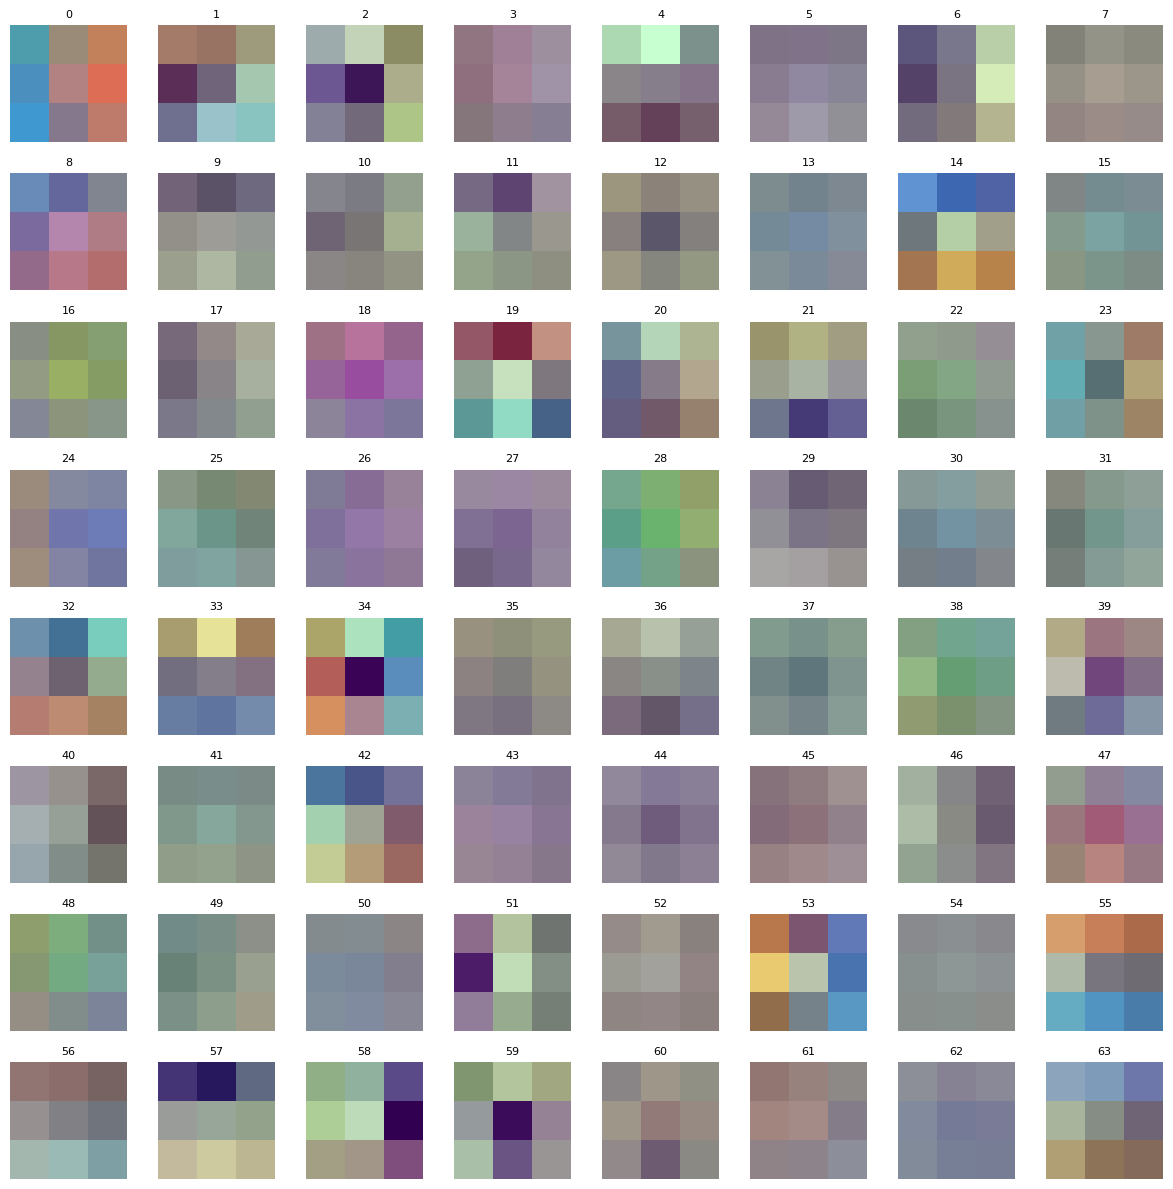

In [49]:
# Get the weights of the first conv layer
filters = model.features[0].weight.data.cpu().numpy()  # Shape: (64, 3, 3, 3)

# Normalize filters for visualization
min_val = filters.min()
max_val = filters.max()
filters = (filters - min_val) / (max_val - min_val)

n_filters = 64  # Total filters in conv1_1
n_rows = 8
n_cols = 8

plt.figure(figsize=(12, 12))
for i in range(n_filters):
    f = filters[i]
    f = np.transpose(f, (1, 2, 0))  # (H, W, C)
    ax = plt.subplot(n_rows, n_cols, i + 1)
    plt.imshow(f)
    plt.axis('off')
    ax.set_title(f'{i}', fontsize=8)
plt.tight_layout()
plt.show()